In [412]:
#@title
#HIDDEN
from IPython.display import display, clear_output
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets
from mpl_toolkits.axisartist import SubplotZero
from IPython.display import YouTubeVideo
from matplotlib.patches import Ellipse, Rectangle, Arc

from matplotlib.ticker import FormatStrFormatter
from scipy import stats
mpl.rc('font', **{'family': 'serif', 'serif':['Computer Modern'], 'size': 14})
mpl.rc('text', usetex=True)
       
%matplotlib inline

In [413]:
#HIDDEN
def arrowed_spines(fig, ax, w_scl=40, l_scl=40, xlim=None, ylim=None):
    '''
    Solution provided in 
    https://stackoverflow.com/questions/33737736/matplotlib-axis-arrow-tip
    '''
    if xlim==None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlim
    if ylim==None:
        ymin, ymax = ax.get_ylim()
    else:
        ymin, ymax = ylim
    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # removing the axis ticks
    ax.set_xticks([]) # labels 
    ax.set_yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./w_scl*(ymax-ymin) 
    hl = 1./l_scl*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False)
    
def add_interval(ax, xdata, ydata, caps="  "):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, zorder=12, c='k'))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 16,
        'color': line.get_color()
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), zorder=12, **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), zorder=12, **anno_args)
    return (line,(a0,a1))

def plot_arrow(ax, theta):
    x_0 = 0
    y_0 = 0
    if theta >= 0:
        y_1 = 0.1
    else:
        y_1 = -0.1
    if theta !=0:
        x_1 = y_1/np.tan(theta)
    else:
        x_1 = y_1/np.tan(1e-8)
    x_h_1 = x_1/np.linalg.norm([x_1, y_1])
    y_h_1 = y_1/np.linalg.norm([x_1, y_1])
    ax.quiver(x_0, y_0, x_h_1*0.75, y_h_1*0.75, units='xy', scale=1, color='gray')
    ax.add_patch(Arc([x_0, y_0], 0.5, y_h_1/2, theta1=0, theta2=np.degrees(np.arctan(y_h_1/x_h_1)), color='gray', lw=2))
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)
    ax.text(x_h_1*0.25+0.1, y_h_1*0.25+0.01, r'$\theta$', c='k', bbox=props)

    ax.set_aspect('equal')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    
def create_multipleChoice_widget(description, options, correct_answer):
    if correct_answer not in options:
        options.append(correct_answer)
    
    correct_answer_index = options.index(correct_answer)
    
    radio_options = [(words, i) for i, words in enumerate(options)]
    alternativ = widgets.RadioButtons(
        options = radio_options,
        description = '',
        disabled = False
    )
    
    description_out = widgets.HTMLMath(description)
        
    feedback_out = widgets.Output()

    def check_selection(b):
        a = int(alternativ.value)
        if a==correct_answer_index:
            s = '\x1b[6;30;42m' + " Congratulations! You're right! " + '\x1b[0m' +"\n" #green color
        else:
            s = '\x1b[5;30;41m' + " Wrong Anwser! Try again!" + '\x1b[0m' +"\n" #red color
        with feedback_out:
            clear_output()
            print(s)
        return
    
    check = widgets.Button(description="Submit!")
    check.on_click(check_selection)
    
    
    return widgets.VBox([description_out, alternativ, check, feedback_out])


def sbs(texts):
    btn_next = widgets.Button(description='Next')
    btn_back = widgets.Button(description='Back')
    btn_back.disabled = True
    texts_disps = []
    total_texts = len(texts)
    for text in texts:
        texts_disps.append(widgets.HTMLMath(text))
    for text_disp in texts_disps:
        text_disp.layout = widgets.Layout(display='none')

    global i_vis 
    i_vis = 0

    def update_vis(i_vis):
        if i_vis == total_texts:
            btn_next.disabled = True
        else:
            btn_next.disabled = False
        if i_vis != 0:
            btn_back.disabled = False
        else:
            btn_back.disabled = True

        for text_disp in texts_disps:
            text_disp.layout = widgets.Layout(display='none')
        for i in range(i_vis):
            try:
                texts_disps[i].layout.display = 'block'
            except:
                pass
    
    def clicked_btn_next(btn_object):
        global i_vis
        i_vis += 1
        update_vis(i_vis)
        
    def clicked_btn_back(btn_object):
        global i_vis
        i_vis -= 1
        update_vis(i_vis)
    
    btn_next.on_click(clicked_btn_next)
    btn_back.on_click(clicked_btn_back)
    bts = widgets.HBox([btn_back, btn_next])
    out = widgets.VBox(texts_disps + [bts], layout=widgets.Layout(width='100%', display='column-flex'))
    return out

# Quick Review

In [Lesson 1](https://murilohmoreira.github.io/host_widgets/lesson_1.html) we found that the defects tips act as stress raisers because of the concentration of force lines around it.

In [414]:
#HIDDEN

def circle(C, R):
    t=np.linspace(0,2*np.pi, 200)
    return C+R*np.exp(1j*t)
def Juc(z, lam):#Joukowski transformation
    return z+(lam**2)/z

def deg2radians(deg):
    return deg*np.pi/180

def compute_lines(rho):
    '''
    Based on the Joukowski transformation of the potential flow past a cylinder.
    For reference:
    https://people.eng.unimelb.edu.au/asho/PotentialFlow/notes.pdf
    https://github.com/luca6331/joukowskiAirfoilVisualization/blob/master/Report.pdf
    https://nbviewer.jupyter.org/github/empet/Math/blob/master/Joukowski-airfoil.ipynb
    
    '''

    V_inf = 1
    R = 1
    lam = (R**2 + R*rho/2 - R*(8*R*rho + rho**2)**0.5/2)**0.5
    alpha=deg2radians(0) # angle of attack
    beta=deg2radians(0)  # -beta is the argument of the complex no (Joukovski parameter - circle center)
    center_c= 0 # Center of the circle
    x=np.arange(-3.5, 3.5, 0.1)
    y=np.arange(-5, 5, 0.1)
    x,y=np.meshgrid(x,y)
    z=x+1j*y
    z=ma.masked_where(np.absolute(z-center_c)<=R, z)
    Z=z-center_c
    Z = -1j*Z
    Gamma=-4*np.pi*V_inf*R*np.sin(beta+alpha)
    U=np.zeros(Z.shape, dtype=np.complex)
    with np.errstate(all='ignore'):#avoid warning when evaluates np.log(0+1jy).
                                         #In this case the arg is arctan(y/0)+cst
            for m in range(Z.shape[0]):
                for n in range(Z.shape[1]):
                    #U[m,n]=Gamma*np.log(Z[m,n]/R)/(2*np.pi)# 
                     U[m,n]=Gamma*np.log((Z[m,n]*np.exp(-1j*alpha))/R)/(2*np.pi)
    c_flow= V_inf*Z*np.exp(-1j*alpha) + (V_inf*np.exp(1j*alpha)*R**2)/Z - 1j*U #the complex flow
    J=Juc(z, lam)
    Circle=circle(0, R)
    Airfoil=Juc(Circle, lam)# airfoil 
    return J, c_flow.imag, Airfoil, rho

In [416]:
#HIDDEN

np.seterr(all='ignore')
def f(rho, defect, show_lines):
    fig, ax = plt.subplots(figsize=(6, 6))
    r = Rectangle([-3.5, -4.75], 6.95, 9.5, facecolor='none', edgecolor='k', zorder=10)
    if not defect:
        if not show_lines:
            ax.add_patch(r)

            
        if show_lines:
            xcoords = np.linspace(-3.5, 3.5, 50)
            ax.add_patch(r)
            for xc in xcoords:
                perf = plt.axvline(x=xc, c='blue', lw=1)
                perf.set_clip_path(r)
    if defect: 
        if not show_lines:
            R = 1
            lam = (R**2 + R*rho/2 - R*(8*R*rho + rho**2)**0.5/2)**0.5
            c = 1
            b = c*rho**0.5
            Circle=circle(0, R)
            Airfoil=Juc(Circle, lam)
            ax.plot(Airfoil.real, Airfoil.imag, c='k')
            ax.add_patch(r)

        if show_lines:
            J, stream_func, Airfoil, rho = compute_lines(rho)
            cp=ax.contour(J.real, J.imag, stream_func,levels=100, colors='blue', linewidths=1,
                            linestyles='solid')# this means that the flow is evaluated at Juc(z) since c_flow(Z)=C_flow(csi(Z))
            ax.add_patch(r)

            for col in cp.collections:
                col.set_clip_path(r)
            ax.plot(Airfoil.real, Airfoil.imag, c='k')
            ax.set_xlim(-5.5, 5.5)
            ax.set_ylim(-5.5, 5.5)
        
    plt.annotate('', xy = (0, 4.725), \
        xytext = (0, 5.5), fontsize = 20, \
        color = '#303030', arrowprops=dict(edgecolor='black', arrowstyle = '<-'))
    plt.text(0.25, 5.25, r'$\sigma_{app}$', fontsize=14)
        
    plt.annotate('', xy = (0, -4.725), \
        xytext = (0, -5.5), fontsize = 20, \
        color = '#303030', arrowprops=dict(edgecolor='black', arrowstyle = '<-'))
    plt.text(0.25, -5.5, r'$\sigma_{app}$', fontsize=14)

    ax.axis('off')
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    plt.show()

interactive_plot = interactive(f, show_lines=widgets.ToggleButton(False, description='Plot Force Lines'),
                               rho=widgets.FloatSlider(value=5,
                                                       min=0.01,
                                                       max=1,
                                                       step=0.01,
                                                       description=r'$\rho$',
                                                       readout_format='.2f'),
                                defect=widgets.ToggleButton(False, description='Add defect'))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot.layout = widgets.Layout(display='flex',
                               flex_flow='column-reverse',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
interactive_plot


interactive(children=(FloatSlider(value=1.0, description='$\\rho$', max=1.0, min=0.01, step=0.01), ToggleButto…

For an elliptical deffect we found:

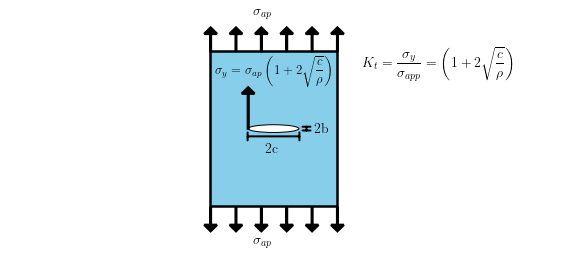

In [420]:
#HIDDEN
fig, ax = plt.subplots(figsize=(10, 4))


r2 = Rectangle([0.3, 0], 0.25, 1, ec='k', lw=2.5, fc='skyblue')
# plt.text(0.3+0.045, 0.85, '$S_2$', fontsize=14, zorder=9)
ax.add_patch(r2)
# plt.plot([0+0.3, 0.2+0.3], [0.3, 0.3], c='k', lw=1.5, zorder=9)
e1 = Ellipse([0.425, 0.5], 0.1, 0.05, zorder=9, fc='w', ec='k')
# plt.arrow(0.4, 0.4, 0.075, 0, head_width=0.075, head_length=0.0,
#           ec='k', lw=2.5, fc='k', zorder=9, stylr='')

plt.annotate(s='', xy=(0.345+0.025,0.45), xytext=(0.455+0.025,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))

plt.text(0.325+0.115/2+0.025, 0.35, '2c', fontsize=14)


plt.annotate(s='', xy=(0.49, 0.475), xytext=(0.49,0.525),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))

plt.text(0.505, 0.475, '2b', fontsize=14)

ax.add_patch(e1)
for i in np.linspace(0.3, 0.55, 6):
    plt.arrow(i+0.001, -0.01, 0, -0.11, head_width=0.025, head_length=0.04,
          ec='k', lw=2.5, fc='k', zorder=9)
    plt.arrow(i+0.001, 1, 0, 0.11, head_width=0.025, head_length=0.04,
          ec='k', lw=2.5, fc='k', zorder=9)

ax.arrow(0.3+0.05+0.025, 0.5, 0, 0.225, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k', zorder=11)
plt.text(0.125+0.16+0.025, 0.8, r'$\sigma_{y} = \sigma_{ap} \left(1 + 2 \sqrt{ \displaystyle \frac{c}{\rho}} \right)$', fontsize=13)
# plt.text(0.095+0.3, 0.34, '$A_1$', fontsize=14, zorder=9)
# ax.arrow(0.1+0.3, -0.01, 0, -0.14, head_width=0.025, head_length=0.04,
#           lw=2.5, fc='k')
# plt.text(0.125+0.3, -0.15, '$F_2$', fontsize=14)
plt.text(0.085+0.3, 1.225, '$\sigma_{ap}$', fontsize=14)
plt.text(0.085+0.3, -0.25, '$\sigma_{ap}$', fontsize=14)

plt.text(0.6, 0.825, r'$K_t = \displaystyle \frac{\sigma_{y}}{\sigma_{app}} = \left(1 + 2 \sqrt{ \displaystyle \frac{c}{\rho}} \right)$', fontsize=14)

# plt.plot([0.3, 0.325], [0.5, 0.5], c='w', lw=2, zorder=4)
# plt.plot([0.475, 0.51], [0.5, 0.5], c='w', lw=2, zorder=4)

ax.set_xlim(-0.1, 1)
ax.set_ylim(-0.2, 1.2)

ax.axis('off')
plt.show()

Now we may consider that we increase $\sigma_{ap}$ until the material fails. In this case, what do you think $\sigma_y$ would be?

We may consider that on the defect tip, we reached the theoretical failure stress that we modeled earlier deriving from the Lennard-Jones potential, that is, mathematically we find that:

\begin{equation}\label{eq:sig_theo_Kt}
\begin{array}{ll}
\sigma_y & = \sigma_{ap}  \ K_t \\
\ \downarrow & \ \ \ \ \downarrow \\
\sigma_{th} & = \sigma_{f} \  K_t
\end{array}
\end{equation}


**Now, the gap between $\sigma_{th}$ and $\sigma_{f}$ shows to us how much one can improve the material's strength by reducing the defects introduced during its processing steps.**

# Irwin Failure Criteria

We recall from our first Lesson the theoretical strength of a material:

\begin{equation}\label{eq:sigma_th}
\sigma_{th} = \sqrt{\frac{E \gamma_0}{a_0}}
\end{equation}


From experimental results one can find the following relationships:

\begin{equation}\label{eq:sth_ineq}
\frac{E}{5} \gt \sigma_{th} \gt \frac{E}{10}
\end{equation}


\begin{equation}\label{eq:sexp_ineq}
\frac{E}{100} \gt \sigma_{th} \gt \frac{E}{1000}
\end{equation}


This difference is explained by the stress intensity factor:

\begin{equation}\label{eq:sf}
\begin{array}{ll}
\sigma_y & = \sigma_{ap}  \ K_t \\
\ \downarrow & \ \ \ \ \downarrow \\
\sigma_{th} & = \sigma_{f} \  K_t
\end{array}
\end{equation}


Which we found it could be defined as:

\begin{equation}\label{eq:sif_def}
K_t = 2 \sqrt{\frac{c}{\rho}}
\end{equation}


Substituting the definition of the stress intensity factor, Equation \ref{eq:sif_def}, into the theoretical strength, Equation \ref{eq:sigma_th} we can find:

\begin{equation}\label{eq:pre_irw}
\sqrt{\frac{E \gamma_0}{a_0}} = 2 \sigma_f \sqrt{\frac{c}{\rho}}
\end{equation}


Solving for the failure stress, $\sigma_f$ we find the Irwin Failure Criteria:
\begin{equation}\label{eq:irwin}
\sigma_f = \left( \frac{E \gamma_0}{a_0} \frac{\rho}{4 c} \right)^{\frac{1}{2}}
\ \ {\text{Irwin Failure Criteria}}
\end{equation}


The first term on the parenthesis is related to properties that are intrinsic to the material. The second term accounts for the geometry and size of the defect. 

We have a natural feeling for deciding which material is ductile and which one is fragile, for example:
<center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">Fragile</th>
    <th class="tg-0lax">Ductile</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">Ice</td>
    <td class="tg-0lax">Steel</td>
  </tr>
  <tr>
    <td class="tg-0lax">Glass</td>
    <td class="tg-0lax">Lead</td>
  </tr>
  <tr>
    <td class="tg-0lax">Chalk</td>
    <td class="tg-0lax">Copper</td>
  </tr>
</tbody>
</table>
</center>    

This however, occurs at room temperature and standard conditions. There are multiple effects such as:
- Temperature effect (i.e. glass $T_g$, Ductile-to-Brittle Transition Temperature)
- Load application rate (piche, polymers)
- Environment conditions (luminosity, humidity, hydrogen)

<span id="call-ref_db_trans" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://yenaengineering.nl/wp-content/uploads/2020/11/fm-3-dbtt-2.png" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 1:</b> Ductile-Brittle transition temperature for mild steel <a href="#cit-ref_db_trans">[1]</a>.</div> </span>


Now let's consider how the tensile stress normal to the crack opening direction decays in front of the crack. For doing this, we consider the Mode I of fracture which is the opening of the crack by tensile stress.

<span id="call-ref_mode" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://www.researchgate.net/profile/Benoit_Derode/publication/258004229/figure/download/fig11/AS:669534277083151@1536640819817/Les-trois-modes-de-rupture-dune-fracture-Mode-I-ouverture-normale-aux-epontes-Mode.png" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 2:</b> The three different modes of fracture: Mode I - tensile opening, Mode II - In plane shear, Mode III - Antiplane shear <a href="#cit-ref_mode">[2]</a>.</div> </span>


This can be visualized in the figure below:

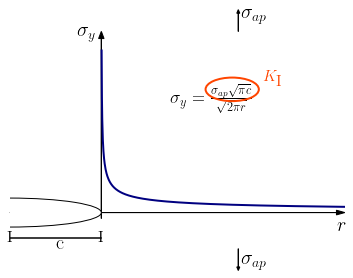

In [10]:
r = np.linspace(1e-3, 1, 1000)
c = 1
sigma_app = 10
fig = plt.figure()
plt.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5, lw=2, c='Navy')
plt.ylim(-50, 250)
plt.xlim(-0.3, 0.8)

e = Ellipse([-0.3, 0], 0.6, 40,  facecolor='w', edgecolor='k', zorder=10)
plt.gca().add_patch(e)
arrowed_spines(fig, plt.gca(), ylim=[-8, 250])
add_interval(plt.gca(), [-0.3, -0.0001], [-35, -35], "II")
plt.text(-0.15, -50, 'c', c='k', fontsize=20)
plt.text(-0.08, 240, '$\sigma_y$', c='k', fontsize=20)
plt.text(0.775, -25, '$r$', c='k', fontsize=20)
plt.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, -75, '$\sigma_{ap}$', c='k', fontsize=20)

plt.arrow(0.45, 250, 0, 30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, 265, '$\sigma_{ap}$', c='k', fontsize=20)
plt.text(0.225, 140, r'$\sigma_y = \frac{\sigma_{ap}\sqrt{\pi c}}{\sqrt{2 \pi r}}$', c='k', fontsize=18)

e = Ellipse([0.43, 170], 0.175, 32.5, lw=2,  facecolor='none', edgecolor='orangered', zorder=10)
plt.gca().add_patch(e)
plt.text(0.53, 175, r'$K_{{\textrm I}}$', c='orangered', fontsize=16)

plt.show()

We can also define the critical stress intensity factor, $K_{Ic}$:

\begin{equation}\label{eq:kic}
\begin{array}{ll}
K_{{\textrm I}} & = \sigma_{ap}  \ \sqrt{\pi c} \\
\ \downarrow & \ \ \ \ \downarrow \\
K_{{\textrm Ic}} & = \sigma_{f} \  \sqrt{\pi c}
\end{array}
\end{equation}


Now consider the following values of failure stress, $\sigma_{f}$, and defect size, $c$:

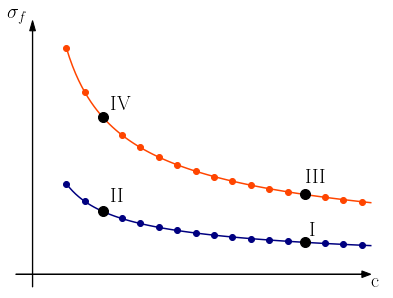

In [81]:
K_Ic_1 = 4
K_Ic_2 = 10
fig = plt.figure()
sigma_f = lambda K_Ic, c: K_Ic/(np.pi*c)**0.5
cs = np.linspace(1e-1, 1, 100)
plt.plot(cs, sigma_f(K_Ic_1, cs), '-o', markevery=6,  c='navy', zorder=5)
plt.plot(cs, sigma_f(K_Ic_2, cs), '-o', markevery=6,  c='orangered', zorder=5)

plt.scatter([0.805], [sigma_f(K_Ic_2, 0.805)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.2075], [sigma_f(K_Ic_2, 0.2075)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.805], [sigma_f(K_Ic_1, 0.805)], marker='o', c='k', s=100, zorder=10)
plt.scatter([0.2075], [sigma_f(K_Ic_1, 0.2075)], marker='o', c='k', s=100, zorder=10)

plt.text(0.805*1.015, sigma_f(K_Ic_1, 0.805)*1.2, r'I', fontsize=20, c='k')
plt.text(0.2075*1.1, sigma_f(K_Ic_1, 0.2075)*1.15, r'II', fontsize=20, c='k')
plt.text(0.805, sigma_f(K_Ic_2, 0.805)*1.15, r'III', fontsize=20, c='k')
plt.text(0.2075*1.1, sigma_f(K_Ic_2, 0.2075)*1.05, r'IV', fontsize=20, c='k')

arrowed_spines(fig, plt.gca(), ylim=[-1, 20], xlim=[-0.05, 1])

plt.text(1, -1, 'c', fontsize=20)
plt.text(-0.075, 20, r'$\sigma_f$', fontsize=20)
# plt.axhline(8, ls='--', c='navy')
# plt.text(0.01, 8.5, r'$\sigma_{ys, 1}$', fontsize=20, c='navy')

# plt.axhline(13, ls='--', c='orangered')
# plt.text(0.01, 13.5, r'$\sigma_{ys, 2}$', fontsize=20, c='orangered')

plt.show()

In [11]:
#HIDDEN
# nbi:right

question = '''
          Which affirmation is right?
          
          <p>a)   $K_{IC, IV} > K_{IC, III} > K_{IC, II} > K_{IC, I}$</p>
          
          <p>b)  $K_{IC, I} > K_{IC, II} > K_{IC, III} > K_{IC, IV}$</p>
          
          <p>c) $K_{IC, IV} = K_{IC, III} > K_{IC, II} = K_{IC, I}$</p>
          
          <p>d) $K_{IC, II} = K_{IC, IV} > K_{IC, III} = K_{IC, I}$</p>
          
          '''
Q1 = create_multipleChoice_widget(question,['a','b','c', 'd'], 'c')
Q1.layout = widgets.Layout(display='flex',
                               flex_flow='column',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
display(Q1)

Consider the next example, we have two different materials:

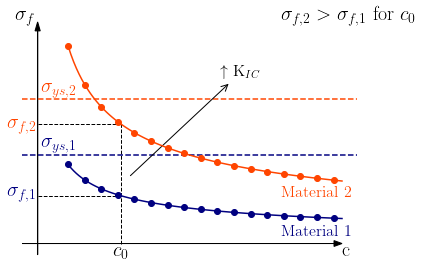

In [94]:
K_Ic_1 = 4
K_Ic_2 = 10
fig = plt.figure()
sigma_f = lambda K_Ic, c: K_Ic/(np.pi*c)**0.5
cs = np.linspace(1e-1, 1, 100)
plt.plot(cs, sigma_f(K_Ic_1, cs), '-o', markevery=6,  c='navy', zorder=5)
plt.text(0.8, 0.75, r'Material 1', fontsize=16, c='navy')
plt.plot(cs, sigma_f(K_Ic_2, cs), '-o', markevery=6,  c='orangered', zorder=5)
plt.text(0.8, 4.25, r'Material 2', fontsize=16, c='orangered')

arrowed_spines(fig, plt.gca(), ylim=[-1, 20], xlim=[-0.05, 1])
plt.annotate(r'$\uparrow$ K$_{IC}$', xy=(0.3, 6), xytext=(0.6, 15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=16)

plt.plot([0.275, 0.275], [0, sigma_f(K_Ic_2, 0.275)], c='k', ls='--', lw=1)
plt.plot([0, 0.275], [sigma_f(K_Ic_1, 0.275), sigma_f(K_Ic_1, 0.275)], c='k', ls='--', lw=1)
plt.plot([0, 0.275], [sigma_f(K_Ic_2, 0.275), sigma_f(K_Ic_2, 0.275)], c='k', ls='--', lw=1)
plt.text(-0.1, sigma_f(K_Ic_1, 0.275)*0.95, r'$\sigma_{f, 1}$', fontsize=20, c='navy')
plt.text(-0.1, sigma_f(K_Ic_2, 0.275)*0.95, r'$\sigma_{f, 2}$', fontsize=20, c='orangered')

plt.text(0.275*0.9, -1.3, r'$c_0$', fontsize=20, c='k')
plt.text(0.8, 20, r'$\sigma_{f, 2} > \sigma_{f, 1}$ for $c_0$', fontsize=20, c='k')

plt.text(1, -1, 'c', fontsize=20)
plt.text(-0.075, 20, r'$\sigma_f$', fontsize=20)
plt.axhline(8, ls='--', c='navy')
plt.text(0.01, 8.5, r'$\sigma_{ys, 1}$', fontsize=20, c='navy')

plt.axhline(13, ls='--', c='orangered')
plt.text(0.01, 13.5, r'$\sigma_{ys, 2}$', fontsize=20, c='orangered')

plt.show()

Consider that we take two perfect samples (single crystals, no defects) of these materials and introduce a single defect of size $c_0$. If we test these samples applying tensile strengths, we see that <span style="color:orangered">Material 2 </span> failure stress is higher than <span style="color:navy">Material 1</span>.



<span id="call-ref_ashby" class="img_container center" style="display: inline_block; vertical-align: top; text-align: center;" > <img alt="test" src="https://upload.wikimedia.org/wikipedia/commons/a/a4/Fracture_toughness_vs._Strength.jpg" style="display:block; margin-left: auto; margin-right: auto; text-align: left;" title="caption" align="center" width="500" height="600" /> <div class="img_caption" style="border-style: solid; border-width: 2px; border-radius: 5px; border-color:lightgrey; padding: 2px 5px; text-align: left; width=980px"><b>Figure 3:</b> Ashby plot of the fracture toughness, $K_{IC}$, and the strength, $\sigma_f$ <a href="#cit-ref_ashby">[3]</a>.</div> </span>



\begin{array}{l}
\sigma_f \ \ \text{(Strength)} \longrightarrow \text { bond energy } \\
\mathrm{K}_{\mathrm{Ic}} \ \ \text{(Fracture Toughness)} \longrightarrow \text { plastic deformation + bond energy }
\end{array}


- Difference between toughness [J/m³] (energy for creating two surface, interaction between microstructure and crack) and fracture toughness [MPa m^1/2] (initiate and propagate the crack)

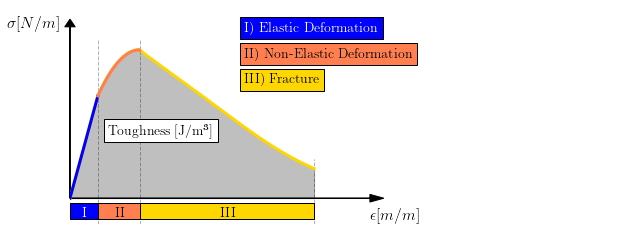

In [404]:
fig, ax = plt.subplots(figsize=(10, 4))
def force(displacement):
    E = 1
    var = -2.5
    force_vals_elastic = E *  displacement[displacement < 0.2] 
    force_vals_non_elastic = E *  displacement[(displacement >= 0.2)*(displacement < 0.5)] +\
                             E *  (displacement[(displacement >= 0.2)*(displacement < 0.5)]**2)[0] -\
                             E *  displacement[(displacement >= 0.2)*(displacement < 0.5)]**2
    x = displacement[(displacement > 0.5)]
    force_vals_break = force_vals_non_elastic[-1] * np.exp(var*(x-1.25)) / (1 + np.exp(var*(x-1.25)))*x**-0.2
    force_vals = np.concatenate([force_vals_elastic, force_vals_non_elastic, force_vals_break])
    return force_vals
x3 = np.linspace(0, 1.75, 1000)
plt.plot(x3, 200*force(x3), c='gold', lw=3)
x1 = np.linspace(0, 0.2, 1000)
plt.plot(x1, 200*force(x1), c='blue', lw=3)
x2 = np.linspace(0.2, 0.5001, 1000)
plt.plot(x2, 200*force(x2), c='coral', lw=3)
x = np.linspace(0, 1.75, 1000)
# plt.plot(x, 200*force(x), c='k', lw=1)
plt.fill_between(x, 200*force(x), color='k', alpha=0.25)

plt.xlim(0, 4)
plt.ylim(-10, 75)
plt.axis('off')
plt.arrow(0, 0, 0, 70., fc='k', ec='k', lw = 1, 
             head_width=0.075, head_length=3,
             length_includes_head= True, clip_on = False)
plt.text(-0.45, 67, r'$\sigma [N/m²]$', c='k', fontsize=16)
plt.arrow(0, 0, 2.25, 0., fc='k', ec='k', lw = 1, 
             head_width=3, head_length=0.1,
             length_includes_head= True, clip_on = False)
plt.text(2.15, -8, r'$\epsilon [m/m]$', c='k', fontsize=16)
r1 = Rectangle([0, -2], 0.2, -6, ec='k', lw=1, fc='blue')
ax.add_patch(r1)
r2 = Rectangle([0.2, -2], 0.3, -6, ec='k', lw=1, fc='coral')
ax.add_patch(r2)
r2 = Rectangle([0.5, -2], 1.25, -6, ec='k', lw=1, fc='gold')
ax.add_patch(r2)
plt.text(0.085, -7, r'I', c='w', fontsize=14)
plt.text(0.32, -7, r'II', c='k', fontsize=14)
plt.text(1.075, -7, r'III', c='k', fontsize=14)
plt.text(1.25, 65, r'I) Elastic Deformation', c='w', fontsize=14, bbox=dict(facecolor='blue'))
plt.text(1.25, 55, r'II) Non-Elastic Deformation', c='k', fontsize=14, bbox=dict(facecolor='coral'))
plt.text(1.25, 45, r'III) Fracture', c='k', fontsize=14, bbox=dict(facecolor='gold'))
plt.text(0.275, 25, r'Toughness [J/m³]', fontweight='bold', c='k', fontsize=14, bbox=dict(facecolor='w'))
plt.axvline(0.2, ymax=0.85, c='k', ls='--', lw=1, zorder=0, alpha=0.3)
plt.axvline(0.5, ymax=0.85, c='k', ls='--', lw=1, zorder=0, alpha=0.3)
plt.axvline(1.75, ymax=0.3, c='k', ls='--', lw=1, zorder=0, alpha=0.3)
plt.show()


- The use of big aggregates (reduce mechanical strength but increases the obstacles for the crack)
- Visualize linear propagation vs nonlinear of crack

- Crack Deflection

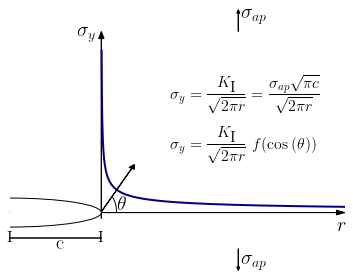

In [6]:
r = np.linspace(1e-3, 1, 1000)
c = 1
sigma_app = 10
fig = plt.figure()
plt.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5, lw=2, c='Navy')
plt.ylim(-50, 250)
plt.xlim(-0.3, 0.8)

e = Ellipse([-0.3, 0], 0.6, 40,  facecolor='w', edgecolor='k', zorder=10)
plt.gca().add_patch(e)
arrowed_spines(fig, plt.gca(), ylim=[-8, 250])
add_interval(plt.gca(), [-0.3, -0.0001], [-35, -35], "II")
plt.text(-0.15, -50, 'c', c='k', fontsize=20)
plt.text(-0.08, 240, '$\sigma_y$', c='k', fontsize=20)
plt.text(0.775, -25, '$r$', c='k', fontsize=20)
plt.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, -75, '$\sigma_{ap}$', c='k', fontsize=20)

plt.arrow(0.45, 250, 0, 30., fc='k', ec='k', lw = 1, 
             head_width=0.01, head_length=5,
             length_includes_head= True, clip_on = False)
plt.text(0.46, 265, '$\sigma_{ap}$', c='k', fontsize=20)
plt.text(0.225, 140, r'$\sigma_y = \displaystyle \frac{K_{\textrm I}}{\sqrt{2 \pi r}} = \frac{\sigma_{ap}\sqrt{\pi c}}{\sqrt{2 \pi r}}$', c='k', fontsize=16)
plt.text(0.225, 70, r'$\sigma_y = \displaystyle \frac{K_{\textrm I}}{\sqrt{2 \pi r}} \ f(\cos{(\theta))}$', c='k', fontsize=16)
ax2 = plt.gca().twinx()
y_0 = 0.17
x_1 = 0.1
y_1 = 0.2
ax2.arrow(0.0, y_0, x_1, y_1, fc='k', ec='k', lw = 1, 
          head_width=0.02, head_length=0.02)
arc = ax2.add_patch(Arc([0, y_0], x_1, y_1, theta1=0, theta2=np.degrees(np.arctan(y_1/x_1)), color='k'))
plt.text(0.0525, 0.18, r'$\theta$', c='k', fontsize=20)

ax2.set_ylim(0, 1)
ax2.axis('off')
plt.show()

<div id="call-ref_book"</div>
The closed form of f is more complex as it is derived from a polar coordinates analysis of the problem. For more information check the work of Professor Brian Lawn <a href="#cit-ref_book">[4]</a>.


 

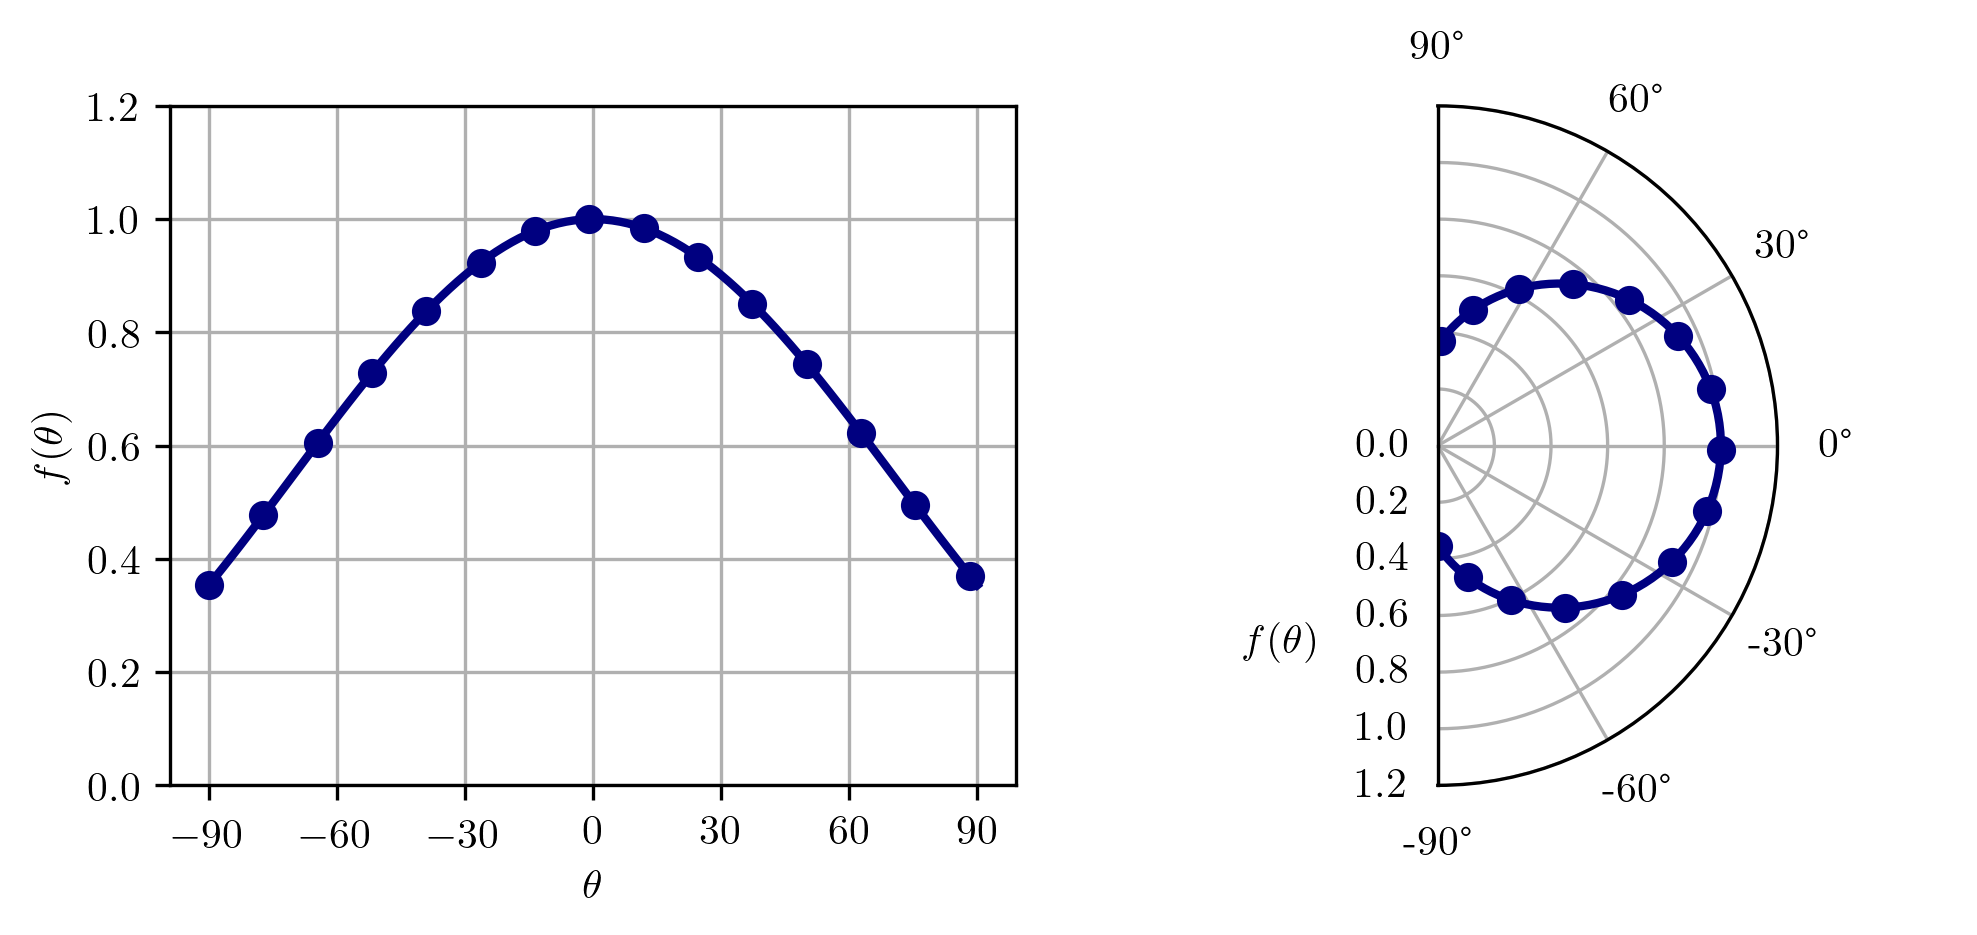

In [7]:
def f_theta(theta):
    return np.cos(theta / 2)**3

# fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True))
fig = plt.figure(figsize=(8, 3), dpi=300)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

thetas = np.linspace(-(np.pi/2), (np.pi/2), 100)
ax1.plot(np.rad2deg(thetas), f_theta(thetas), '-o', markevery=7, c='navy', lw=2)
ax1.set_ylim(0, 1.2)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$f(\theta)$')
ax1.set_xticks(np.linspace(-90, 90, 7))
ax1.grid()

ax2.plot(thetas, f_theta(thetas), '-o', markevery=7, c='navy', lw=2)
ax2.set_ylim(0, 1.2)
# plt.ylim(-np.pi/2, np.pi/2)
ax2.set_xlim(-np.pi/2, np.pi/2)
ax2.set_xticks(np.linspace(-np.pi/2, np.pi/2, 7))
ax2.text(-np.pi/1.35, 1., r'$f(\theta)$')
# axs[1].projection('polar')
plt.show()

You can visualize the effect of the crack deflection on the example below. Change the values of the angle theta below and see how the stress at the tip of the defect changes:

In [8]:
def see_theta(theta_deg):
    theta = np.deg2rad(theta_deg)
    c = 1
    sigma_app = 30
    fig = plt.figure(figsize=(8, 3), dpi=300)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, projection='polar')
    r = np.linspace(1e-3, 1, 1000)
    ax1.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5 * f_theta(theta), lw=2, c='Navy')
    ax1.plot(r, sigma_app * (np.pi * c)**0.5 / (2*np.pi*r)**0.5 * f_theta(0), lw=1, ls='--', c='Navy', label=r'$\sigma_y$ with $\theta=0$')

    ax1.set_ylim(-150, 150)
    e = Ellipse([-0.45, 0], 0.9, 40,  facecolor='w', edgecolor='k', zorder=10)
    ax1.add_patch(e)
    r = Rectangle([-0.9, -25], 0.45, 45,  facecolor='w', edgecolor='w', zorder=11)
    ax1.add_patch(r)
    arrowed_spines(fig, ax1, ylim=[-8, 250], xlim=[-0.2, 1])
    ax1.annotate(s='', xy=(-0.3, -35), xytext=(-0.0001,-35),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=1))
    
    ax1.text(-0.175, -55, 'c', c='k', fontsize=14)
    ax1.text(-0.175, 240, '$\sigma_y$', c='k', fontsize=14)
    ax1.text(0.975, -25, '$r$', c='k', fontsize=14)
    ax1.set_xlim(-0.3, 0.8)
    ax1.axis('off')
    ax1.legend(fontsize=8)
    ax3 = ax1.twinx()
    ax3.axis('off')
    plot_arrow(ax3, theta)
    ax1.arrow(0.45, -50, 0, -30., fc='k', ec='k', lw = 1, 
          head_width=0.05, head_length=5,
          length_includes_head= True, clip_on = False)
    ax1.text(0.485, -75, '$\sigma_{ap}$', c='k', fontsize=12)

    ax1.arrow(0.45, 220, 0, 30., fc='k', ec='k', lw = 1, 
              head_width=0.05, head_length=5,
              length_includes_head= True, clip_on = False)
    ax1.text(0.485, 230, '$\sigma_{ap}$', c='k', fontsize=12)
    
#     ax2.set_title(r'$f(\theta)$')
    ax2.plot([theta, theta], [0, 1.2])
    ax2.plot(thetas, f_theta(thetas), '-', markevery=7, c='navy', lw=2)
    ax2.plot(theta, f_theta(theta),'-o', c='orangered', zorder=3)
    ax2.plot([theta]*5, [0, 0.2, 0.4, 0.8, 1.2], '-', c='k')
    ax2.set_ylim(0.2, 1.2)
    # plt.ylim(-np.pi/2, np.pi/2)
    ax2.set_xlim(-np.pi/2, np.pi/2)
    ax2.set_xticks(np.linspace(-np.pi/2, np.pi/2, 7))
#     ax2.text(-np.pi/1.35, 1., r'$f(\theta)$')
#     ax1.set_position([-0.2, 0.6, 0.5, 0.4])
#     ax2.set_position([0.35,0.6, 0.5, 0.4])
#     plt.tight_layout()
interactive_plot = interactive(see_theta, theta_deg=widgets.FloatSlider(value=0,
                                                       min=-90,
                                                       max=90,
                                                       step=5,
                                                       description=r'$\theta \ [°]$',
                                                       readout_format='.2f'))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot.layout = widgets.Layout(display='flex',
                               flex_flow='column',
                               align_items='center',
                               align_content='center',
                               justify_content='center',
                               width='100%')
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='$\\theta \\ [°]$', max=90.0, min=-90.0, step=5.0), O…

This have plenty of effects and explains one of the most common toughening mechanism, the *crack deflection*.

Now consider the definition of the fracture toughness, Equation \ref{eq:kic} and solve for $\sigma_f$:

\begin{equation}\label{eq:sig_f}
\sigma_f = \dfrac{K_{IC}}{\sqrt{\pi c}}
\end{equation}

We see that the greater the size of the defect, the lower the failure stress. Conversely, when we increase the fracture toughness, the material is less susceptible to the defect size.

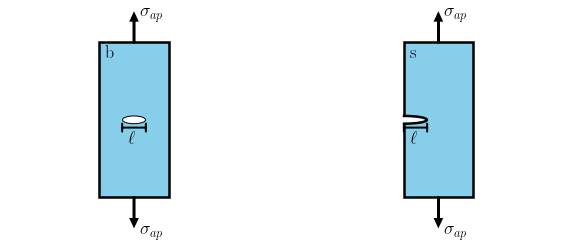

In [189]:
#HIDDEN

fig, axs = plt.subplots(1, 2, figsize=(10, 4))


r2 = Rectangle([0.3, 0], 0.3, 1, ec='k', lw=2.5, fc='skyblue')
axs[0].add_patch(r2)
e1 = Ellipse([0.45, 0.5], 0.1, 0.05, zorder=9, fc='w', ec='k')
axs[0].add_patch(e1)

axs[0].arrow(0.1+0.3+0.05, 1, 0, 0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[0].text(0.125+0.3+0.05, 1.15, '$\sigma_{ap}$', fontsize=18)
axs[0].arrow(0.1+0.3+0.05, 0, 0, -0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[0].text(0.125+0.3+0.05, -0.25, '$\sigma_{ap}$', fontsize=18)

r2 = Rectangle([0.3, 0], 0.3, 1, ec='k', lw=2.5, fc='skyblue')
axs[1].add_patch(r2)
e1 = Ellipse([0.3, 0.5], 0.2, 0.05, zorder=9, fc='w', ec='k', lw=2.5)
axs[1].add_patch(e1)
r3 = Rectangle([0.19, 0], 0.1, 1, ec='w', lw=2.5, fc='w', zorder=10)
axs[1].add_patch(r3)


axs[1].arrow(0.1+0.3+0.05, 1, 0, 0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[1].text(0.125+0.3+0.05, 1.15, '$\sigma_{ap}$', fontsize=18)
axs[1].arrow(0.1+0.3+0.05, 0, 0, -0.14, head_width=0.025, head_length=0.04,
          lw=2.5, fc='k')
axs[1].text(0.125+0.3+0.05, -0.25, '$\sigma_{ap}$', fontsize=18)

axs[0].annotate(s='', xy=(0.39,0.45), xytext=(0.51,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))
axs[0].text(0.425, 0.35, r'$\ell$', fontsize=18, zorder=10)

axs[1].annotate(s='', xy=(0.29,0.45), xytext=(0.41,0.45),
             arrowprops=dict(arrowstyle='|-|, widthA=0.4,widthB=0.4', linewidth=2))
axs[1].text(0.325, 0.35, r'$\ell$', fontsize=18, zorder=10)

axs[0].text(0.325, 0.9, 'b', fontsize=18, zorder=10)
axs[1].text(0.325, 0.9, 's', fontsize=18, zorder=10)



for ax in axs:
    ax.axis('off')
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.2, 1.2)

plt.show()

Both samples are made of the same material, thus $K_{IC}$ is the same.

\begin{equation*}
\sigma_f = \dfrac{K_{IC}}{\sqrt{\pi c}}
\end{equation*}

\begin{equation*}
\sigma_{f, b} \ \sqrt{\pi \dfrac{\ell}{2}} = \sigma_{f, s} \ \sqrt{\pi \ell}
\end{equation*}

\begin{equation*}
\sigma_{f, b}^2 \ \pi \dfrac{\ell}{2} = \sigma_{f, s}^2 \ \pi \ell
\end{equation*}

\begin{equation*}
\dfrac{\sigma_{f, b}^2}{\sigma_{f, s}^2} = 2
\end{equation*}

\begin{equation*}
\dfrac{\sigma_{f, b}}{\sigma_{f, s}} = \sqrt{2}
\end{equation*}

\begin{equation*}
\sigma_{f, s} = 0.7 \sigma_{f, b}
\end{equation*}

This result is of fundamental importance as it shows that for defects of same sizes, the defects on the surface are more critical as the mechanical strength of the sample with the defect on the surface is lower than the one with the defect in the bulk.

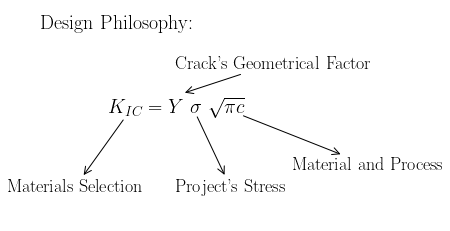

In [248]:
fig, axs = plt.subplots()
plt.text(0.1, 0.9, 'Design Philosophy:', fontsize=20)

plt.text(0.3, 0.5, '$K_{IC} = Y \ \sigma \ \sqrt{\pi c}$', fontsize=20)
plt.annotate('Materials Selection', xy=(0.35, 0.485), xytext=(0., 0.15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)

plt.annotate('Crack\'s Geometrical Factor', xy=(0.525, 0.6), xytext=(0.5, 0.715),
             arrowprops=dict(arrowstyle='->', linewidth=1), fontsize=18)

plt.annotate('Project\'s Stress', xy=(0.565, 0.5), xytext=(0.5, 0.15),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)

plt.annotate('Material and Process', xy=(0.7, 0.5), xytext=(0.85, 0.25),
             arrowprops=dict(arrowstyle='<-', linewidth=1), fontsize=18)


plt.gca().axis('off')
plt.show()

- Add animation of moagem
- Al2O3 example

# References

[1] <a href="https://yenaengineering.nl/ductile-brittle-transition-temperature-and-impact-energy-tests/" target="_blank" rel="noopener noreferrer">Yena Engineering, Ductile-Brittle Transition Temperature and Impact Energy Tests.</a> <a id="cit-ref_db_trans" href="#call-ref_db_trans">[↩]</a>

[2] <a href="https://www.researchgate.net/publication/258004229_In-situ_experimental_study_of_the_seismic_signatures_of_the_role_of_fluids_in_the_rupture_of_fault_zones_Application_to_large_rockslides_failure_studies/figures?lo=1&utm_source=bing&utm_medium=organic" target="_blank" rel="noopener noreferrer">Deroide B., In-situ experimental study of the seismic signatures of the role of fluids in the rupture of fault zones: Application to large rockslides failure studies.</a> <a id="cit-ref_modes" href="#call-ref_mode">[↩]</a>

[3] <a href="https://commons.wikimedia.org/wiki/File:Fracture_toughness_vs._Strength.jpg" target="_blank" rel="noopener noreferrer">Wikimedia Commons, the free media repository, Fracture toughness vs. Strength.</a> <a id="cit-ref_ashby" href="#call-ref_ashby">[↩]</a>

[4] <a href="https://www.cambridge.org/core/books/fracture-of-brittle-solids/B1EC1413BDBA1DCF49E1665D4B0A20F3" target="_blank" rel="noopener noreferrer">Lawn B., Fracture of Brittle Solids. Page 46</a> <a id="cit-ref_book" href="#call-ref_book">[↩]</a>